In [14]:
ban='_1636542394.616689_1_0.5861_0.6916'
batch_size=4

In [2]:
import torch

device0 = torch.device('cuda:5' if torch.cuda.is_available() else "cpu")

device1 = torch.device('cuda:5' if torch.cuda.is_available() else "cpu")

In [3]:
# 读数据
import pandas as pd
df_train=pd.read_excel("../data/df_train.xlsx",index_col=0)
df_test=pd.read_excel("../data/df_test.xlsx",index_col=0)

In [4]:
import ast
label18=[]
for i in range(len(df_train)):
    new_list=[]
    old_list=ast.literal_eval(df_train.loc[i]['label'])
    df_train.loc[i]['label']=old_list
    for j in old_list:
        if j==0:
            new_list+=[0,0,0]
        if j==1:
            new_list+=[0,0,1]
        if j==2:
            new_list+=[0,1,1]
        if j==3:
            new_list+=[1,1,1]
    label18.append(new_list)

df_train['label18']=label18

In [5]:
label18=[]
for i in range(len(df_test)):
    new_list=[]
    old_list=ast.literal_eval(df_test.loc[i]['label'])
    df_test.loc[i]['label']=old_list
    for j in old_list:
        if j==0:
            new_list+=[0,0,0]
        if j==1:
            new_list+=[0,0,1]
        if j==2:
            new_list+=[0,1,1]
        if j==3:
            new_list+=[1,1,1]
    label18.append(new_list)

df_test['label18']=label18

In [6]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
df_train_text=[df_train['text'][i] for i in range(len(df_train))]
df_test_text=[df_test['text'][i] for i in range(len(df_test))]


In [7]:
text2id_train = tokenizer(
        df_train_text, max_length=100, padding='max_length', truncation=True, return_tensors="pt"
    )
input_ids_train=text2id_train["input_ids"]
mask_train=text2id_train["attention_mask"]

text2id_test = tokenizer(
        df_test_text, max_length=100, padding='max_length', truncation=True, return_tensors="pt"
    )
input_ids_test=text2id_test["input_ids"]
mask_test=text2id_test["attention_mask"]


In [8]:
df_train['input_ids']=input_ids_train.tolist()
df_train['mask']=mask_train.tolist()

df_test['input_ids']=input_ids_test.tolist()
df_test['mask']=mask_test.tolist()

In [9]:
from torch.utils.data import Dataset
class SentimentDataset(Dataset):
    def __init__(self,df):
        self.dataset = df
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        text = self.dataset.loc[idx, "text"]
        label = self.dataset.loc[idx, "label"]
#         print(label)
        input_ids = self.dataset.loc[idx, "input_ids"]
        mask = self.dataset.loc[idx, "mask"]
        label18=self.dataset.loc[idx, "label18"]
        sample = {"text": text, "label": label,"label18": label18,"input_ids":input_ids,"mask":mask}
        # print(sample)
        return sample

In [10]:
#按batch_size分
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import torch

train_loader = DataLoader(
    SentimentDataset(df_train), 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0
)
print(train_loader)

test_loader = DataLoader(
    SentimentDataset(df_test), 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0
)
print(test_loader)

In [11]:
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.nn.functional as F


class fn_cls(nn.Module):
    def __init__(self,device):
        super(fn_cls, self).__init__()
        self.model = AutoModel.from_pretrained("bert-base-chinese")
        self.model.to(device)
        self.dropout = nn.Dropout(0.5)
        self.l1 = nn.Linear(768, 18)

    def forward(self, x, attention_mask=None):
        outputs = self.model(x, attention_mask=attention_mask)
        x = outputs[1]
        x = self.dropout(x)
        x = self.l1(x)
        return x

In [12]:
sigmoid = nn.Sigmoid()

In [15]:
import torch

if ban==0:
    cls = fn_cls(device0)
    cls.train()
else:
    cls=torch.load("../data/cls"+str(ban)+".model",map_location=device0)

In [29]:
def _18to6_(output,round_=0):#18tensor 变 6list
    output0=[]
    for j in output:#18
        i=0
        s=''
        list6=[]
        while(i<len(j)):
            ok=j[i]*1.2+j[i+1]*1.1+j[i+2]*1
            if round_==1:
                list6.append(ok.round().int().tolist())
            else:
                list6.append(ok.tolist())
            i+=3
        output0.append(list6)
    return output0

def get_loss_test(output,A,round_=0):#8*18
    output_r=torch.Tensor(_18to6_(output,round_=1)).to(device0)
    output=_18to6_(output,round_=round_)
    # print(output_r,A)
    cor_add=(output_r == A).sum().item()
    sum0=0
    for i in range(len(output)):
        for j in range(6):
            sum0+=(output[i][j]-A[i][j])*(output[i][j]-A[i][j])
    return sum0,cor_add

def test(device_test):
    cls.to(device_test)
    cls.eval()

    correct = 0
    total = 0
    loss_test=0
    for batch_idx,batch in enumerate(test_loader):
        with torch.no_grad():
            # print(batch['label'],batch['label18'])
            label6=torch.stack(batch['label']).t().to(device_test).float()
            # label18=torch.stack(batch['label18']).t().to(device_test).float()

            input_ids=torch.stack(batch['input_ids']).t().to(device_test)
            mask=torch.stack(batch['mask']).t().to(device_test)

            output = cls(input_ids, attention_mask=mask)
            output=sigmoid(output)

            total += len(output)*6
            loss_add,cor_add = get_loss_test(output, label6 ,round_=1)
            loss_test+=loss_add
            correct+=cor_add

            tes_score=1/(1+(loss_test/total) ** 0.5)
            acc_score=100.*correct/total

        

        print('[{}/{} ({:.0f}%)]\t正确分类的样本数：{}，样本总数：{}，准确率：{:.2f}%，score：{}'.format(
                    batch_idx, len(test_loader),100.*batch_idx/len(test_loader), 
                    correct, total,acc_score,
                    tes_score
            ),end='\r')
    print('[{}/{} ({:.0f}%)]\t正确分类的样本数：{}，样本总数：{}，准确率：{:.2f}%，score：{}'.format(
                    batch_idx, len(test_loader),100.*batch_idx/len(test_loader), 
                    correct, total,acc_score,
                    tes_score
            ))
#     cls.to(device_train)
    return tes_score,acc_score


In [22]:
t_score,t_acc=test(device1)

[0/1670 (0%)]	正确分类的样本数：20，样本总数：24，准确率：83.33%，score：0.7101020216941833
[1/1670 (0%)]	正确分类的样本数：41，样本总数：48，准确率：85.42%，score：0.723651111125946
[2/1670 (0%)]	正确分类的样本数：63，样本总数：72，准确率：87.50%，score：0.7387961149215698
[3/1670 (0%)]	正确分类的样本数：85，样本总数：96，准确率：88.54%，score：0.7471041083335876
[4/1670 (0%)]	正确分类的样本数：106，样本总数：120，准确率：88.33%，score：0.7453981041908264
[5/1670 (0%)]	正确分类的样本数：127，样本总数：144，准确率：88.19%，score：0.7442734837532043
[6/1670 (0%)]	正确分类的样本数：150，样本总数：168，准确率：89.29%，score：0.7533940076828003
[7/1670 (0%)]	正确分类的样本数：171，样本总数：192，准确率：89.06%，score：0.7514735460281372
[8/1670 (0%)]	正确分类的样本数：194，样本总数：216，准确率：89.81%，score：0.758068323135376
[9/1670 (1%)]	正确分类的样本数：216，样本总数：240，准确率：90.00%，score：0.7597469091415405
[10/1670 (1%)]	正确分类的样本数：237，样本总数：264，准确率：89.77%，score：0.7478872537612915
[11/1670 (1%)]	正确分类的样本数：260，样本总数：288，准确率：90.28%，score：0.7529646158218384
[12/1670 (1%)]	正确分类的样本数：281，样本总数：312，准确率：90.06%，score：0.7518159747123718
[13/1670 (1%)]	正确分类的样本数：304，样本总数：336，准确率：90.48%，score：0.756001532077789

[113/1670 (7%)]	正确分类的样本数：2444，样本总数：2736，准确率：89.33%，score：0.7419382333755493
[114/1670 (7%)]	正确分类的样本数：2467，样本总数：2760，准确率：89.38%，score：0.7424851655960083
[115/1670 (7%)]	正确分类的样本数：2489，样本总数：2784，准确率：89.40%，score：0.7427386045455933
[116/1670 (7%)]	正确分类的样本数：2510，样本总数：2808，准确率：89.39%，score：0.7418566346168518
[117/1670 (7%)]	正确分类的样本数：2532，样本总数：2832，准确率：89.41%，score：0.7421099543571472
[118/1670 (7%)]	正确分类的样本数：2553，样本总数：2856，准确率：89.39%，score：0.7412522435188293
[119/1670 (7%)]	正确分类的样本数：2575，样本总数：2880，准确率：89.41%，score：0.7415050864219666
[120/1670 (7%)]	正确分类的样本数：2599，样本总数：2904，准确率：89.50%，score：0.7422996163368225
[121/1670 (7%)]	正确分类的样本数：2620，样本总数：2928，准确率：89.48%，score：0.7422705292701721
[122/1670 (7%)]	正确分类的样本数：2640，样本总数：2952，准确率：89.43%，score：0.7419734597206116
[123/1670 (7%)]	正确分类的样本数：2661，样本总数：2976，准确率：89.42%，score：0.7419475317001343
[124/1670 (7%)]	正确分类的样本数：2683，样本总数：3000，准确率：89.43%，score：0.7413956522941589
[125/1670 (7%)]	正确分类的样本数：2705，样本总数：3024，准确率：89.45%，score：0.7416355609893799
[126/1670 (8

[222/1670 (13%)]	正确分类的样本数：4782，样本总数：5352，准确率：89.35%，score：0.7445499300956726
[223/1670 (13%)]	正确分类的样本数：4801，样本总数：5376，准确率：89.30%，score：0.7442235350608826
[224/1670 (13%)]	正确分类的样本数：4820，样本总数：5400，准确率：89.26%，score：0.7439008355140686
[225/1670 (13%)]	正确分类的样本数：4843，样本总数：5424，准确率：89.29%，score：0.7441744208335876
[226/1670 (14%)]	正确分类的样本数：4865，样本总数：5448，准确率：89.30%，score：0.7442981600761414
[227/1670 (14%)]	正确分类的样本数：4887，样本总数：5472，准确率：89.31%，score：0.7444208860397339
[228/1670 (14%)]	正确分类的样本数：4907，样本总数：5496，准确率：89.28%，score：0.7442490458488464
[229/1670 (14%)]	正确分类的样本数：4927，样本总数：5520，准确率：89.26%，score：0.743642270565033
[230/1670 (14%)]	正确分类的样本数：4950，样本总数：5544，准确率：89.29%，score：0.7439104914665222
[231/1670 (14%)]	正确分类的样本数：4972，样本总数：5568，准确率：89.30%，score：0.7440323829650879
[232/1670 (14%)]	正确分类的样本数：4993，样本总数：5592，准确率：89.29%，score：0.7440094947814941
[233/1670 (14%)]	正确分类的样本数：5014，样本总数：5616，准确率：89.28%，score：0.7435578107833862
[234/1670 (14%)]	正确分类的样本数：5036，样本总数：5640，准确率：89.29%，score：0.7436793446540833


[329/1670 (20%)]	正确分类的样本数：7036，样本总数：7920，准确率：88.84%，score：0.738018810749054
[330/1670 (20%)]	正确分类的样本数：7056，样本总数：7944，准确率：88.82%，score：0.7379245758056641
[331/1670 (20%)]	正确分类的样本数：7077，样本总数：7968，准确率：88.82%，score：0.737927258014679
[332/1670 (20%)]	正确分类的样本数：7098，样本总数：7992，准确率：88.81%，score：0.7379298806190491
[333/1670 (20%)]	正确分类的样本数：7117，样本总数：8016，准确率：88.78%，score：0.737741231918335
[334/1670 (20%)]	正确分类的样本数：7139，样本总数：8040，准确率：88.79%，score：0.7378396391868591
[335/1670 (20%)]	正确分类的样本数：7159，样本总数：8064，准确率：88.78%，score：0.7377474904060364
[336/1670 (20%)]	正确分类的样本数：7180，样本总数：8088，准确率：88.77%，score：0.7377505898475647
[337/1670 (20%)]	正确分类的样本数：7202，样本总数：8112，准确率：88.78%，score：0.737848162651062
[338/1670 (20%)]	正确分类的样本数：7222，样本总数：8136，准确率：88.77%，score：0.7374747395515442
[339/1670 (20%)]	正确分类的样本数：7243，样本总数：8160，准确率：88.76%，score：0.7374786734580994
[340/1670 (20%)]	正确分类的样本数：7262，样本总数：8184，准确率：88.73%，score：0.737295925617218
[341/1670 (20%)]	正确分类的样本数：7278，样本总数：8208，准确率：88.67%，score：0.7368364334106445
[342

[436/1670 (26%)]	正确分类的样本数：9201，样本总数：10488，准确率：87.73%，score：0.7263932228088379
[437/1670 (26%)]	正确分类的样本数：9221，样本总数：10512，准确率：87.72%，score：0.7261538505554199
[438/1670 (26%)]	正确分类的样本数：9239，样本总数：10536，准确率：87.69%，score：0.7253872752189636
[439/1670 (26%)]	正确分类的样本数：9262，样本总数：10560，准确率：87.71%，score：0.7255479693412781
[440/1670 (26%)]	正确分类的样本数：9281，样本总数：10584，准确率：87.69%，score：0.7252481579780579
[441/1670 (26%)]	正确分类的样本数：9302，样本总数：10608，准确率：87.69%，score：0.7252772450447083
[442/1670 (26%)]	正确分类的样本数：9322，样本总数：10632，准确率：87.68%，score：0.72524094581604
[443/1670 (27%)]	正确分类的样本数：9345，样本总数：10656，准确率：87.70%，score：0.7252047657966614
[444/1670 (27%)]	正确分类的样本数：9369，样本总数：10680，准确率：87.72%，score：0.7254288196563721
[445/1670 (27%)]	正确分类的样本数：9391，样本总数：10704，准确率：87.73%，score：0.7255223393440247
[446/1670 (27%)]	正确分类的样本数：9414，样本总数：10728，准确率：87.75%，score：0.7256802916526794
[447/1670 (27%)]	正确分类的样本数：9435，样本总数：10752，准确率：87.75%，score：0.7257081270217896
[448/1670 (27%)]	正确分类的样本数：9458，样本总数：10776，准确率：87.77%，score：0.72586

[542/1670 (32%)]	正确分类的样本数：11459，样本总数：13032，准确率：87.93%，score：0.727849006652832
[543/1670 (33%)]	正确分类的样本数：11480，样本总数：13056，准确率：87.93%，score：0.7278683185577393
[544/1670 (33%)]	正确分类的样本数：11497，样本总数：13080，准确率：87.90%，score：0.7273468971252441
[545/1670 (33%)]	正确分类的样本数：11512，样本总数：13104，准确率：87.85%，score：0.7270441651344299
[546/1670 (33%)]	正确分类的样本数：11529，样本总数：13128，准确率：87.82%，score：0.7265295386314392
[547/1670 (33%)]	正确分类的样本数：11546，样本总数：13152，准确率：87.79%，score：0.7258595824241638
[548/1670 (33%)]	正确分类的样本数：11564，样本总数：13176，准确率：87.77%，score：0.7253008484840393
[549/1670 (33%)]	正确分类的样本数：11584，样本总数：13200，准确率：87.76%，score：0.7251138091087341
[550/1670 (33%)]	正确分类的样本数：11604，样本总数：13224，准确率：87.75%，score：0.7249277234077454
[551/1670 (33%)]	正确分类的样本数：11624，样本总数：13248，准确率：87.74%，score：0.724742591381073
[552/1670 (33%)]	正确分类的样本数：11644，样本总数：13272，准确率：87.73%，score：0.7242984771728516
[553/1670 (33%)]	正确分类的样本数：11663，样本总数：13296，准确率：87.72%，score：0.7233421206474304
[554/1670 (33%)]	正确分类的样本数：11679，样本总数：13320，准确率：87.68%，

[647/1670 (39%)]	正确分类的样本数：13624，样本总数：15552，准确率：87.60%，score：0.7194014191627502
[648/1670 (39%)]	正确分类的样本数：13641，样本总数：15576，准确率：87.58%，score：0.7192588448524475
[649/1670 (39%)]	正确分类的样本数：13664，样本总数：15600，准确率：87.59%，score：0.7193717360496521
[650/1670 (39%)]	正确分类的样本数：13687，样本总数：15624，准确率：87.60%，score：0.7194843888282776
[651/1670 (39%)]	正确分类的样本数：13709，样本总数：15648，准确率：87.61%，score：0.7195543050765991
[652/1670 (39%)]	正确分类的样本数：13730，样本总数：15672，准确率：87.61%，score：0.719581663608551
[653/1670 (39%)]	正确分类的样本数：13748，样本总数：15696，准确率：87.59%，score：0.7193551659584045
[654/1670 (39%)]	正确分类的样本数：13772，样本总数：15720，准确率：87.61%，score：0.7195094227790833
[655/1670 (39%)]	正确分类的样本数：13793，样本总数：15744，准确率：87.61%，score：0.7195367217063904
[656/1670 (39%)]	正确分类的样本数：13814，样本总数：15768，准确率：87.61%，score：0.7195639610290527
[657/1670 (39%)]	正确分类的样本数：13834，样本总数：15792，准确率：87.60%，score：0.7195490598678589
[658/1670 (39%)]	正确分类的样本数：13855，样本总数：15816，准确率：87.60%，score：0.7195761799812317
[659/1670 (39%)]	正确分类的样本数：13878，样本总数：15840，准确率：87.61%

[756/1670 (45%)]	正确分类的样本数：15879，样本总数：18168，准确率：87.40%，score：0.7177318334579468
[757/1670 (45%)]	正确分类的样本数：15897，样本总数：18192，准确率：87.38%，score：0.7175416350364685
[758/1670 (45%)]	正确分类的样本数：15914，样本总数：18216，准确率：87.36%，score：0.7172088623046875
[759/1670 (45%)]	正确分类的样本数：15931，样本总数：18240，准确率：87.34%，score：0.7168778777122498
[760/1670 (46%)]	正确分类的样本数：15953，样本总数：18264，准确率：87.35%，score：0.7169399857521057
[761/1670 (46%)]	正确分类的样本数：15975，样本总数：18288，准确率：87.35%，score：0.7168951630592346
[762/1670 (46%)]	正确分类的样本数：15996，样本总数：18312，准确率：87.35%，score：0.7168149352073669
[763/1670 (46%)]	正确分类的样本数：16017，样本总数：18336，准确率：87.35%，score：0.7167350053787231
[764/1670 (46%)]	正确分类的样本数：16039，样本总数：18360，准确率：87.36%，score：0.7166907787322998
[765/1670 (46%)]	正确分类的样本数：16060，样本总数：18384，准确率：87.36%，score：0.7163995504379272
[766/1670 (46%)]	正确分类的样本数：16080，样本总数：18408，准确率：87.35%，score：0.7160746455192566
[767/1670 (46%)]	正确分类的样本数：16097，样本总数：18432，准确率：87.33%，score：0.7156463861465454
[768/1670 (46%)]	正确分类的样本数：16116，样本总数：18456，准确率：87.32

[868/1670 (52%)]	正确分类的样本数：18160，样本总数：20856，准确率：87.07%，score：0.7127645015716553
[869/1670 (52%)]	正确分类的样本数：18182，样本总数：20880，准确率：87.08%，score：0.7128217816352844
[870/1670 (52%)]	正确分类的样本数：18203，样本总数：20904，准确率：87.08%，score：0.7127583026885986
[871/1670 (52%)]	正确分类的样本数：18222，样本总数：20928，准确率：87.07%，score：0.7124544382095337
[872/1670 (52%)]	正确分类的样本数：18243，样本总数：20952，准确率：87.07%，score：0.7124817371368408
[873/1670 (52%)]	正确分类的样本数：18263，样本总数：20976，准确率：87.07%，score：0.7124789357185364
[874/1670 (52%)]	正确分类的样本数：18286，样本总数：21000，准确率：87.08%，score：0.712566077709198
[875/1670 (52%)]	正确分类的样本数：18308，样本总数：21024，准确率：87.08%，score：0.7126231789588928
[876/1670 (52%)]	正确分类的样本数：18328，样本总数：21048，准确率：87.08%，score：0.7126202583312988
[877/1670 (53%)]	正确分类的样本数：18349，样本总数：21072，准确率：87.08%，score：0.7126471996307373
[878/1670 (53%)]	正确分类的样本数：18367，样本总数：21096，准确率：87.06%，score：0.7125846147537231
[879/1670 (53%)]	正确分类的样本数：18390，样本总数：21120，准确率：87.07%，score：0.7125817537307739
[880/1670 (53%)]	正确分类的样本数：18411，样本总数：21144，准确率：87.07%

[979/1670 (59%)]	正确分类的样本数：20429，样本总数：23520，准确率：86.86%，score：0.7046761512756348
[980/1670 (59%)]	正确分类的样本数：20447，样本总数：23544，准确率：86.85%，score：0.7046312093734741
[981/1670 (59%)]	正确分类的样本数：20470，样本总数：23568，准确率：86.86%，score：0.7047121524810791
[982/1670 (59%)]	正确分类的样本数：20492，样本总数：23592，准确率：86.86%，score：0.7046170234680176
[983/1670 (59%)]	正确分类的样本数：20509，样本总数：23616，准确率：86.84%，score：0.7043469548225403
[984/1670 (59%)]	正确分类的样本数：20528，样本总数：23640，准确率：86.84%，score：0.7041029334068298
[985/1670 (59%)]	正确分类的样本数：20547，样本总数：23664，准确率：86.83%，score：0.7038598656654358
[986/1670 (59%)]	正确分类的样本数：20564，样本总数：23688，准确率：86.81%，score：0.7034937143325806
[987/1670 (59%)]	正确分类的样本数：20584，样本总数：23712，准确率：86.81%，score：0.7035002708435059
[988/1670 (59%)]	正确分类的样本数：20604，样本总数：23736，准确率：86.80%，score：0.703432559967041
[989/1670 (59%)]	正确分类的样本数：20626，样本总数：23760，准确率：86.81%，score：0.7034885287284851
[990/1670 (59%)]	正确分类的样本数：20642，样本总数：23784，准确率：86.79%，score：0.7033963799476624
[991/1670 (59%)]	正确分类的样本数：20663，样本总数：23808，准确率：86.79%

[1085/1670 (65%)]	正确分类的样本数：22612，样本总数：26064，准确率：86.76%，score：0.6988266706466675
[1086/1670 (65%)]	正确分类的样本数：22634，样本总数：26088，准确率：86.76%，score：0.6988800764083862
[1087/1670 (65%)]	正确分类的样本数：22657，样本总数：26112，准确率：86.77%，score：0.6989550590515137
[1088/1670 (65%)]	正确分类的样本数：22681，样本总数：26136，准确率：86.78%，score：0.6990517377853394
[1089/1670 (65%)]	正确分类的样本数：22704，样本总数：26160，准确率：86.79%，score：0.6991266012191772
[1090/1670 (65%)]	正确分类的样本数：22728，样本总数：26184，准确率：86.80%，score：0.6992230415344238
[1091/1670 (65%)]	正确分类的样本数：22747，样本总数：26208，准确率：86.79%，score：0.6990808248519897
[1092/1670 (65%)]	正确分类的样本数：22770，样本总数：26232，准确率：86.80%，score：0.6991555094718933
[1093/1670 (65%)]	正确分类的样本数：22794，样本总数：26256，准确率：86.81%，score：0.699251651763916
[1094/1670 (66%)]	正确分类的样本数：22813，样本总数：26280，准确率：86.81%，score：0.6990450024604797
[1095/1670 (66%)]	正确分类的样本数：22835，样本总数：26304，准确率：86.81%，score：0.6990331411361694
[1096/1670 (66%)]	正确分类的样本数：22857，样本总数：26328，准确率：86.82%，score：0.6990858912467957
[1097/1670 (66%)]	正确分类的样本数：22876，样本总数：263

[1191/1670 (71%)]	正确分类的样本数：24826，样本总数：28608，准确率：86.78%，score：0.6988962292671204
[1192/1670 (71%)]	正确分类的样本数：24843，样本总数：28632，准确率：86.77%，score：0.6988458633422852
[1193/1670 (71%)]	正确分类的样本数：24861，样本总数：28656，准确率：86.76%，score：0.6988153457641602
[1194/1670 (71%)]	正确分类的样本数：24882，样本总数：28680，准确率：86.76%，score：0.6988441348075867
[1195/1670 (72%)]	正确分类的样本数：24904，样本总数：28704，准确率：86.76%，score：0.6988334655761719
[1196/1670 (72%)]	正确分类的样本数：24925，样本总数：28728，准确率：86.76%，score：0.6988030076026917
[1197/1670 (72%)]	正确分类的样本数：24946，样本总数：28752，准确率：86.76%，score：0.6988316774368286
[1198/1670 (72%)]	正确分类的样本数：24965，样本总数：28776，准确率：86.76%，score：0.6988210678100586
[1199/1670 (72%)]	正确分类的样本数：24985，样本总数：28800，准确率：86.75%，score：0.6988300681114197
[1200/1670 (72%)]	正确分类的样本数：25005，样本总数：28824，准确率：86.75%，score：0.6987800598144531
[1201/1670 (72%)]	正确分类的样本数：25027，样本总数：28848，准确率：86.75%，score：0.698828399181366
[1202/1670 (72%)]	正确分类的样本数：25046，样本总数：28872，准确率：86.75%，score：0.6987000107765198
[1203/1670 (72%)]	正确分类的样本数：25065，样本总数：288

[1296/1670 (78%)]	正确分类的样本数：26942，样本总数：31128，准确率：86.55%，score：0.6960987448692322
[1297/1670 (78%)]	正确分类的样本数：26962，样本总数：31152，准确率：86.55%，score：0.6961089968681335
[1298/1670 (78%)]	正确分类的样本数：26984，样本总数：31176，准确率：86.55%，score：0.6961548328399658
[1299/1670 (78%)]	正确分类的样本数：27002，样本总数：31200，准确率：86.54%，score：0.6959694623947144
[1300/1670 (78%)]	正确分类的样本数：27025，样本总数：31224，准确率：86.55%，score：0.6960330009460449
[1301/1670 (78%)]	正确分类的样本数：27046，样本总数：31248，准确率：86.55%，score：0.6960077285766602
[1302/1670 (78%)]	正确分类的样本数：27065，样本总数：31272，准确率：86.55%，score：0.6960002779960632
[1303/1670 (78%)]	正确分类的样本数：27086，样本总数：31296，准确率：86.55%，score：0.6960282325744629
[1304/1670 (78%)]	正确分类的样本数：27109，样本总数：31320，准确率：86.55%，score：0.6960915923118591
[1305/1670 (78%)]	正确分类的样本数：27132，样本总数：31344，准确率：86.56%，score：0.6961548924446106
[1306/1670 (78%)]	正确分类的样本数：27153，样本总数：31368，准确率：86.56%，score：0.6961296200752258
[1307/1670 (78%)]	正确分类的样本数：27176，样本总数：31392，准确率：86.57%，score：0.6961928606033325
[1308/1670 (78%)]	正确分类的样本数：27197，样本总数：31

[1403/1670 (84%)]	正确分类的样本数：29176，样本总数：33696，准确率：86.59%，score：0.6931102275848389
[1404/1670 (84%)]	正确分类的样本数：29198，样本总数：33720，准确率：86.59%，score：0.6931537985801697
[1405/1670 (84%)]	正确分类的样本数：29220，样本总数：33744，准确率：86.59%，score：0.6931971907615662
[1406/1670 (84%)]	正确分类的样本数：29242，样本总数：33768，准确率：86.60%，score：0.6932407021522522
[1407/1670 (84%)]	正确分类的样本数：29266，样本总数：33792，准确率：86.61%，score：0.6933161616325378
[1408/1670 (84%)]	正确分类的样本数：29288，样本总数：33816，准确率：86.61%，score：0.6933594942092896
[1409/1670 (84%)]	正确分类的样本数：29311，样本总数：33840，准确率：86.62%，score：0.6934189200401306
[1410/1670 (84%)]	正确分类的样本数：29335，样本总数：33864，准确率：86.63%，score：0.6934942007064819
[1411/1670 (84%)]	正确分类的样本数：29359，样本总数：33888，准确率：86.64%，score：0.6935694813728333
[1412/1670 (85%)]	正确分类的样本数：29382，样本总数：33912，准确率：86.64%，score：0.6936286687850952
[1413/1670 (85%)]	正确分类的样本数：29405，样本总数：33936，准确率：86.65%，score：0.6936877369880676
[1414/1670 (85%)]	正确分类的样本数：29425，样本总数：33960，准确率：86.65%，score：0.6936987042427063
[1415/1670 (85%)]	正确分类的样本数：29446，样本总数：33

[1509/1670 (90%)]	正确分类的样本数：31457，样本总数：36240，准确率：86.80%，score：0.6962266564369202
[1510/1670 (90%)]	正确分类的样本数：31478，样本总数：36264，准确率：86.80%，score：0.6962506771087646
[1511/1670 (90%)]	正确分类的样本数：31496，样本总数：36288，准确率：86.79%，score：0.6962288022041321
[1512/1670 (91%)]	正确分类的样本数：31517，样本总数：36312，准确率：86.79%，score：0.6962527632713318
[1513/1670 (91%)]	正确分类的样本数：31538，样本总数：36336，准确率：86.80%，score：0.6962767839431763
[1514/1670 (91%)]	正确分类的样本数：31557，样本总数：36360，准确率：86.79%，score：0.6962701082229614
[1515/1670 (91%)]	正确分类的样本数：31576，样本总数：36384，准确率：86.79%，score：0.6962635517120361
[1516/1670 (91%)]	正确分类的样本数：31597，样本总数：36408，准确率：86.79%，score：0.6962874531745911
[1517/1670 (91%)]	正确分类的样本数：31617，样本总数：36432，准确率：86.78%，score：0.6962960362434387
[1518/1670 (91%)]	正确分类的样本数：31638，样本总数：36456，准确率：86.78%，score：0.6963199377059937
[1519/1670 (91%)]	正确分类的样本数：31658，样本总数：36480，准确率：86.78%，score：0.6963285207748413
[1520/1670 (91%)]	正确分类的样本数：31676，样本总数：36504，准确率：86.77%，score：0.6963067054748535
[1521/1670 (91%)]	正确分类的样本数：31697，样本总数：36

[1612/1670 (97%)]	正确分类的样本数：33493，样本总数：38712，准确率：86.52%，score：0.6958626508712769
[1613/1670 (97%)]	正确分类的样本数：33512，样本总数：38736，准确率：86.51%，score：0.6958566904067993
[1614/1670 (97%)]	正确分类的样本数：33532，样本总数：38760，准确率：86.51%，score：0.6958650350570679
[1615/1670 (97%)]	正确分类的样本数：33553，样本总数：38784，准确率：86.51%，score：0.6958876848220825
[1616/1670 (97%)]	正确分类的样本数：33571，样本总数：38808，准确率：86.51%，score：0.6958674192428589
[1617/1670 (97%)]	正确分类的样本数：33588，样本总数：38832，准确率：86.50%，score：0.695747435092926
[1618/1670 (97%)]	正确分类的样本数：33607，样本总数：38856，准确率：86.49%，score：0.695741593837738
[1619/1670 (97%)]	正确分类的样本数：33627，样本总数：38880，准确率：86.49%，score：0.6957500576972961
[1620/1670 (97%)]	正确分类的样本数：33646，样本总数：38904，准确率：86.48%，score：0.6957441568374634
[1621/1670 (97%)]	正确分类的样本数：33665，样本总数：38928，准确率：86.48%，score：0.6957383155822754
[1622/1670 (97%)]	正确分类的样本数：33682，样本总数：38952，准确率：86.47%，score：0.6957041025161743
[1623/1670 (97%)]	正确分类的样本数：33702，样本总数：38976，准确率：86.47%，score：0.6957125067710876
[1624/1670 (97%)]	正确分类的样本数：33721，样本总数：3900

In [17]:
from torch import optim
#BCEWithLogitsLoss就是把Sigmoid-BCELoss合成一步
criterion = nn.BCELoss()
criterion_hui=nn.MSELoss()
optimizer = optim.Adam(cls.parameters(), lr=1e-4)

_________________________________________________________________
_________________________________________________________________
_________________ epoch:4 start _________________
_________________________________________________________________
_________________________________________________________________
labels: tensor([[0., 0., 0., 0., 0., 0.],.708996	准确率：90.61%
        [0., 0., 0., 3., 0., 0.]], device='cuda:5')
pred: tensor([[0.0098, 0.0094, 0.0181, 0.0138, 0.0443, 0.0322],
        [0.0260, 0.0676, 0.3466, 0.9530, 0.1184, 0.1782]], device='cuda:5')
Train Epoch: 4	score:0.708987	准确率：90.61%
[1669/1670 (100%)]	正确分类的样本数：34753，样本总数：40080，准确率：86.71%，score：0.6890657544136047
epoch: 4_执行时间:  1190.2982199192047
_________________________________________________________________
_________________________________________________________________
_________________ epoch:4 end _________________
_________________________________________________________________
_______________________________

TypeError: can't convert cuda:5 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

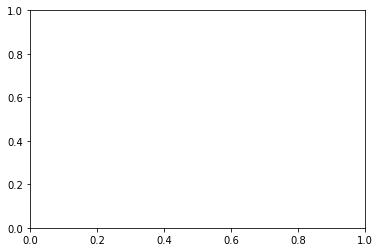

In [33]:
import time  # 引入time模块
 

import torch
import matplotlib.pyplot as plt

def train(device_train,device_test,epoch_be=0):
    epoch_num=4
    accumulation_steps=32
    
    train_score=[]
    test_score=[]
    test_acc=[]

    for epoch_idx in range(epoch_be,epoch_be+epoch_num):
        cls.to(device_train)
        print("_________________________________________________________________")
        print("_________________________________________________________________")
        print("_________________ epoch:"+str(epoch_idx)+" start _________________")
        print("_________________________________________________________________")
        print("_________________________________________________________________")
        score_list=[]
        loss_a=0
        total=0
        correct=0
        start = time.time()
        for batch_idx,batch in enumerate(train_loader):
            label6=torch.stack(batch['label']).t().to(device_test).float()
            label18=torch.stack(batch['label18']).t().to(device_test).float()

            #计算output
            input_ids=torch.stack(batch['input_ids']).t().to(device_train)
            mask=torch.stack(batch['mask']).t().to(device_train)
            output = cls(input_ids, attention_mask=mask)
            output=sigmoid(output)
            output6=torch.Tensor(_18to6_(output,round_=0)).to(device_train)


            # 梯度积累
            loss0 = criterion(output, label18)
            lossh=criterion_hui(output6,label6)

            loss=loss0+lossh
            loss = loss/accumulation_steps
            loss.backward()

            #计算score
            with torch.no_grad():
                total += len(output)*6
                loss_add,cor_add = get_loss_test(output, label6,round_=0)
                loss_a+=loss_add
                correct+=cor_add

                tr_score=1/(1+(loss_a/total) ** 0.5)
                acc_score=100.*correct/total


            if((batch_idx+1) % accumulation_steps) == 0:
                # 每 accumulation_steps 次更新一下网络中的参数
                optimizer.step()
                optimizer.zero_grad()

            if ((batch_idx+1) % accumulation_steps) == 1:
                score_list.append(tr_score)
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tscore:{:.6f}\t准确率：{:.2f}%'.format(
                    epoch_idx, batch_idx, len(train_loader), 
                    100.*batch_idx/len(train_loader), tr_score,acc_score
                ),end='\r')

        #每个epoch结束：
        print('labels:', label6)
        print('pred:', output6)
#         plt.plot([i for i in range(len(score_list))], score_list)
#         plt.show()

        print('Train Epoch: {}\tscore:{:.6f}\t准确率：{:.2f}%'.format(epoch_idx,tr_score,acc_score))
        t_score,t_acc=test(device_test)

        train_score.append(tr_score)
        test_score.append(t_score)
        test_acc.append(t_acc)

        #保存模型
        end = time.time()
        print('epoch:',str(epoch_idx)+'_执行时间: ',end - start)
        torch.save(cls,"../data/cls_"+str(end)+"_"+str(epoch_idx)+"_"+str(round(tr_score.tolist(),4))+"_"+str(round(t_score.tolist(),4))+".model")

        print("_________________________________________________________________")
        print("_________________________________________________________________")
        print("_________________ epoch:"+str(epoch_idx)+" end _________________")
        print("_________________________________________________________________")
        print("_________________________________________________________________")

    plt.plot([i for i in range(len(train_score))], train_score)
    plt.show()             

    plt.plot([i for i in range(len(test_score))], test_score)
    plt.show()

    plt.plot([i for i in range(len(test_acc))], test_acc)
    plt.show()
    
train(device0,device1,epoch_be=4)


In [31]:
end = time.time()
torch.save(cls,"../data/cls_"+str(end)+"_"+str(2)+"_"+str(0.6886)+"_"+str(0.6942)+".model")


In [35]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")

def get_output(device_pre,model,text,f=0):
    model.to(device_pre)
    model.eval()
    text2id = tokenizer(
        text, max_length=100, padding='max_length', truncation=True, return_tensors="pt"
    )
#     print(text,text2id)
    input_ids=text2id["input_ids"].to(device_pre)
    mask=text2id["attention_mask"].to(device_pre)
#         print(text2id)
    output = model(input_ids, attention_mask=mask)
    print(output)
    output=sigmoid(output)
    print(output)
    
#     output=sigmoid(output)*4
    if f==1:
        return _18to6_(output,round_=1)
    else:
        return _18to6_(output,round_=0)

In [36]:
text = ['*与n3：啊？']
# 爱、乐、惊、怒、恐、哀
print(get_output(device1,cls,text,0))

tensor([[-6.9952, -6.0604, -5.4647, -7.4934, -6.1120, -5.5436, -2.6384, -0.2311,
          1.5884, -6.6223, -5.7481, -4.5401, -5.4886, -4.1617, -2.5640, -6.0817,
         -5.3633, -4.8412]], device='cuda:5', grad_fn=<AddmmBackward0>)
tensor([[9.1540e-04, 2.3281e-03, 4.2157e-03, 5.5645e-04, 2.2112e-03, 3.8972e-03,
         6.6708e-02, 4.4248e-01, 8.3039e-01, 1.3286e-03, 3.1787e-03, 1.0560e-02,
         4.1168e-03, 1.5342e-02, 7.1493e-02, 2.2791e-03, 4.6637e-03, 7.8357e-03]],
       device='cuda:5', grad_fn=<SigmoidBackward0>)
[[0.007875097915530205, 0.006997216492891312, 1.3971621990203857, 0.01565060205757618, 0.09330970048904419, 0.015700681135058403]]
